In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
#Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine


from meshGen import mesh2DLaminates

In [2]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.1







## 3. All together
### 3.1. Reference Solution 

In [4]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=maxh_edges, fullProblemX=True, rotated=True, modelHalfAir=False, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

Boundaries {'right', 'itop', 'ileft', 'iright', 'ibottom', 'bottom', 'left', 'top'}
Materials {'insulation', 'outer', 'inner'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 4.079175163188973     
CG iteration 2, residual = 3.7534611013716286e-14     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( Norm(-grad(sol_ref)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
Draw(lam* Norm(-grad(sol_ref)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)


energy:	0.025518002777672882


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 3.2 Multiscale 

In [7]:
import cempy as cp
modelHalfAir=False
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=False, domainNameHalfAir="multiscale", maxh_edges=maxh_edges, rotated=True, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)


('outer', 'outer', 'multiscale', 'gap', 'gap')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

In [55]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1

from cempy.phiFunctions import Lobatto, dxLobatto
cl_Phi.phiFunction = Lobatto
cl_Phi.dzPhiFunction = dxLobatto



def calcMultiscale(useGradients=True, drawPhis=True):

    # microshape functions
    orderPhi = [
            cl_Phi(1, fes_order=order0, material="multiscale|gap", dirichlet="left|right", useGradients=True, useAbsolutes=True), 

            cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet="left|right", inAir=False), 
            cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet="left|right", inIron=False), 

            # cl_Phi(4, fes_order=1, material="multiscale|gap", dirichlet="left|right", useGradients=True, inAir=False, modelHalfAir=False), 
            # cl_Phi(4, fes_order=1, material="multiscale|gap", dirichlet="left|right", useGradients=True, inIron=False, modelHalfAir=False), 
        ]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi, nFig=1)

    VSpace = []
    # # u0 
    VSpace.append(H1(meshMS, order=order0, dirichlet="left|right")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True)

    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) * dx("multiscale")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda1, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) * dx("gap")


    # h = specialcf.mesh_size
    # um = sum([cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1] for i in range(len(cl_gradgradMS.u))])
    # vm = sum([cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1] for i in range(len(cl_gradgradMS.v))])
    # if True:
        # a += 4*order0**2/h * (um - cl_gradgradMS.trials[0])* (vm - cl_gradgradMS.tests[0]) * ds("ileft|iright", skeleton=True)
        # a += 4*order0**2/h * (cl_gradgradMS.trials[1] - cl_gradgradMS.trials[0])* (cl_gradgradMS.tests[1] - cl_gradgradMS.tests[0]) * ds("ibottom|itop")



    n = specialcf.normal(2)


    def jumpdn(v,vhat):
        return n*(grad(v)-vhat)
    def hesse(v):
        return v.Operator("hesse")
    def hessenn(v):
        return InnerProduct(n, hesse(v)*n)


    if False:
        a +=  (\
            getIntegrand4BFI(cl_gradgradMS.gradu_trace, cl_gradgradMS.v,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) \
            - getIntegrand4BFI(cl_gradgradMS.gradu_trace, [cl_gradgradMS.v[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) \
            + getIntegrand4BFI([cl_gradgradMS.gradu_trace[0]], cl_gradgradMS.v,  lambda1, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) \
            - getIntegrand4BFI([cl_gradgradMS.gradu_trace[0]], [cl_gradgradMS.v[0]],  lambda1, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True) \
        ) * ds("itop|ibottom")



    trials = cl_gradgradMS.trials
    tests = cl_gradgradMS.tests

    h = specialcf.mesh_size
    alpha = 3
    if True:
        a += -alpha*order0**2/h  * getIntegrand4BFI(cl_gradgradMS.gradu_trace, cl_gradgradMS.gradv_trace,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds("itop|ibottom")
        a += alpha*order0**2/h  * getIntegrand4BFI(cl_gradgradMS.gradu_trace, [cl_gradgradMS.gradv_trace[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds("itop|ibottom")
        a += -alpha*order0**2/h  * getIntegrand4BFI([cl_gradgradMS.gradu_trace[0]], [cl_gradgradMS.gradv_trace[0]],  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds("itop|ibottom")
        a += alpha*order0**2/h  * getIntegrand4BFI([cl_gradgradMS.gradu_trace[0]], cl_gradgradMS.gradv_trace,  lambda2, lambda1, force_full_Phi=True, modelHalfAir=False, force_num_int=True)  *ds("itop|ibottom")



    prec = Preconditioner(a,type="direct") 


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, cl_gradgradMS = calcMultiscale(False, drawPhis=False)
print(energy_ref, energy_MS)
# print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


CG iteration 1, residual = 8.018110143233187     
CG iteration 2, residual = 1.337529154402975e-13     
0.025518002777672882 0.026969025618542964


In [48]:
print(f"energy:\t{energy_MS}")
Draw(sum(sol_comp_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": 0.01})
# Draw( Norm(sum(H_comp)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
# Draw( lam * Norm(sum(H_comp)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)

energy:	0.026969025618542898


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 1.3 Comparison 

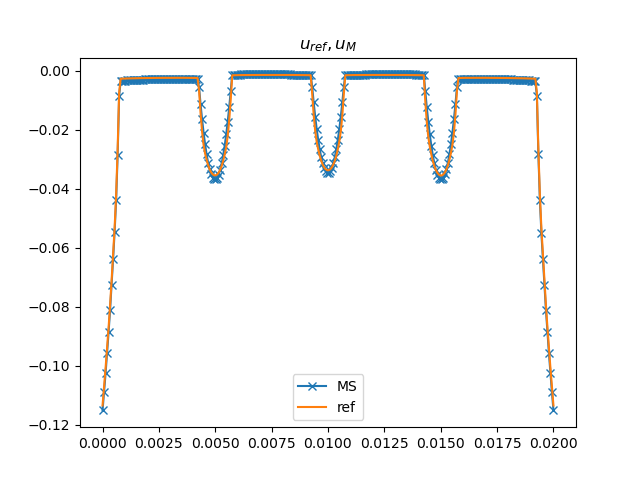

In [49]:

start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(2)
start = -d/2
end = d/2




evalOnLine(sum(sol_comp_MS) , meshRef, [-d/2, start, 0], [-d/2, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=300);
evalOnLine(sol_ref , meshRef, [-d/2, start, 0], [-d/2, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 300, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()

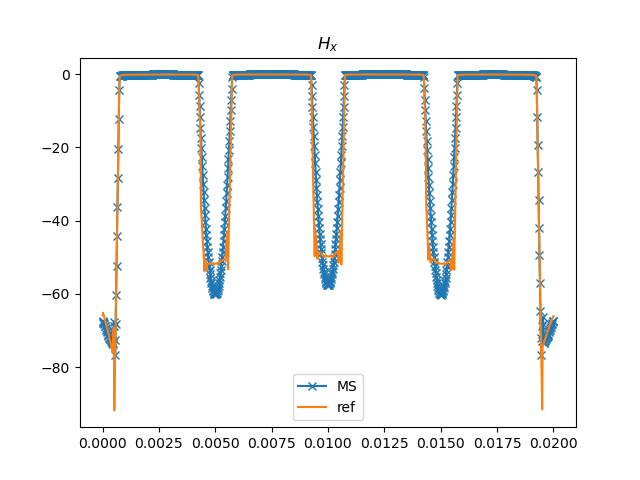

In [50]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(sum(H_comp)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

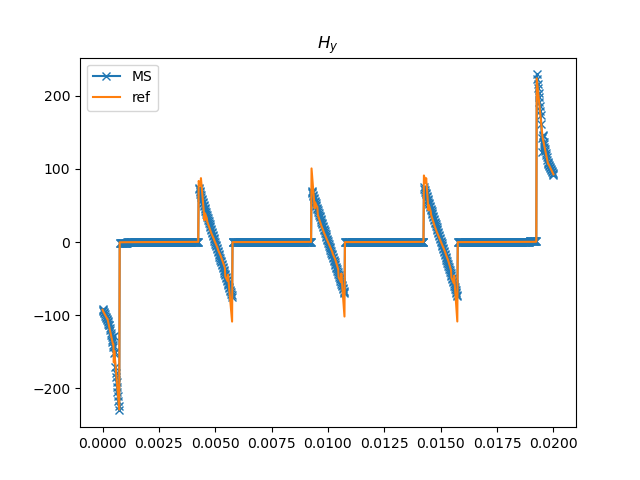

In [51]:
start = -d/2
end = d/2


plt.figure(4)
evalOnLine(sum(H_comp)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");


plt.legend()
plt.show()

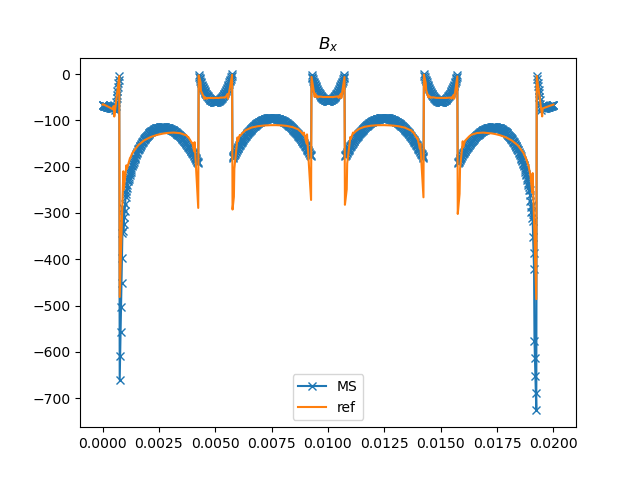

In [52]:
start = -d/2
end = d/2


plt.figure(5)
evalOnLine(lam * sum(H_comp)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(lam * (H_comp[0])[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()

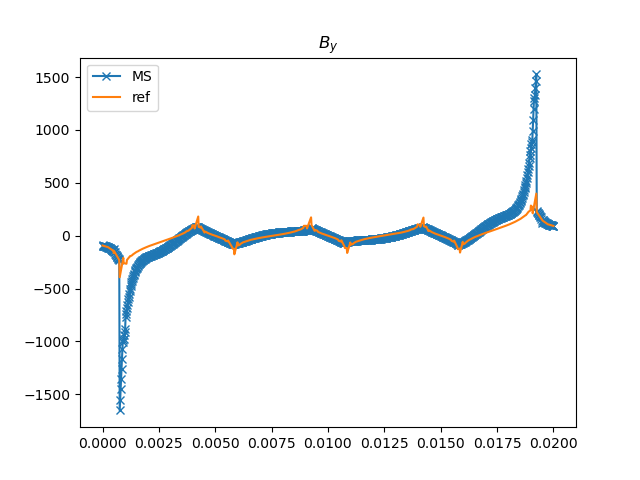

In [53]:
start = -d/2
end = d/2

plt.figure(6)
evalOnLine(lam * sum(H_comp)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(lam * (H_comp[0])[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);

evalOnLine(-lam * grad(sol_ref)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

In [35]:
print(f"energy:\t{energy_MS}")
Draw(IfPos(y, sol_ref, sum(sol_comp_MS)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	0.025159323241107902


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [36]:
Draw(IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = -10)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [37]:
Draw(lam * IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
Draw(lam * IfPos(y, -grad(sol_ref), sum(H_comp))[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), sum(H_comp))[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [38]:

import cempy as cp
o = cl_Phi(2, fes_order=0, material="multiscale", phiFunction=cp.phiFunctions.specialLobatto, dzPhiFunction=cp.phiFunctions.dxspecialLobatto)

In [39]:
Draw(lam, meshRef)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [20]:
print("Norm soll diff", Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref)




Norm soll diff 5.035011050237667e-07
diff energy 0.025048125343663425 0.025518002777672882 -0.00046987743400945733
